1. Users in test? 107068

In [1]:
DATA_PATH = "data"

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime 
from pathlib import Path
from tqdm.notebook import tqdm
import os

%matplotlib inline 

In [3]:
submission_df = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
test_user_ids = submission_df.Id
print("Unique test users:", test_user_ids.nunique())
submission_df.head(3)

Unique test users: 107068


,Id,Predicted
0,51,3239211 10720024 8493844 1965540 5009002 95218...
1,65,11693356 13392267 2464515 2245175 4748570 1134...
2,766,12773054 3692749 12726751 10041624 11893515 23...


In [4]:
def replace_date(date_str):
    if len(date_str) < 8:
        return '2020-10-09'
    else:
        return date_str

def str2date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except:
        date = datetime.datetime.strptime(date_str, '%d.%m.%Y')
    return date

def calculate_age(born):
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    if age < 10 or age > 70:
        age = 0
    return age

In [5]:
## Preprocess Users
user_df = pd.read_csv(os.path.join(DATA_PATH, "kaggle_tab_1345/tab_4_user_profiles.csv"))

uniq = user_df.user_id.nunique()
print(
    f"Users in original file {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Filter users not in test
user_df = user_df[user_df.user_id.isin(test_user_ids)]
uniq = user_df.user_id.nunique()
print(f"After filtering {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Drop duplicates (352 / ~2% of the data)
user_df.drop_duplicates("user_id", inplace=True)

# Drop NaNs
user_df.dropna(inplace=True)
uniq = user_df.user_id.nunique()
print(f"After droping duplicates and NaN's {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")


# Replace incorrect dates
user_df.bdate = user_df.bdate.map(lambda x: replace_date(x))
# Convert all dates to datetime object
user_df.bdate = user_df.bdate.map(lambda x: str2date(x))
# Add new column with age
user_df["age"] = user_df.bdate.map(lambda x: calculate_age(x))
# Drop bdate column
user_df.drop(columns="bdate", inplace=True)
# Label code column
user_df.gender = user_df.gender.astype('category').cat.codes

print(f"Sanity check. Should be same as previous {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")
user_df.head()

Users in original file 438867, unique 436927, diff 1940
After filtering 20764, unique 20412, diff 352
After droping duplicates and NaN's 8254, unique 8254, diff 0
Sanity check. Should be same as previous 8254, unique 8254, diff 0


,user_id,gender,age
10,1288925,1,38
43,1780454,0,0
48,534410,0,29
73,1050790,0,33
85,2119485,0,28


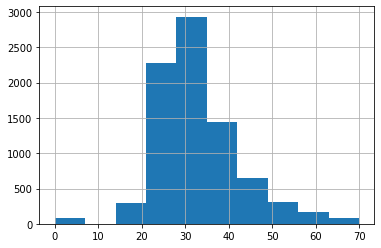

In [6]:
user_df.age.hist()

In [7]:
## Preprocess Citys
city_df = pd.read_csv(os.path.join(DATA_PATH, "tab_6_city.csv"))
city_df.city_name = city_df.city_name.astype('category').cat.codes
city_df.head(3)

,store_id,city_name
0,14,45
1,21,45
2,1,45


In [8]:
# diff is because correct primary key is [order_id, store_id]

## Preprocess Orders
orders_df = pd.read_csv(os.path.join(DATA_PATH, "kaggle_tab_1345/tab_1_orders.csv"))
uniq = orders_df.order_id.nunique()
print(f"Rows in original file {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
# Filter orders only from test users
orders_df = orders_df[orders_df.user_id.isin(test_user_ids)]
uniq = orders_df.order_id.nunique()
print(f"After filtering {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Drop duplicates
orders_df.drop_duplicates(["order_id", "store_id"], inplace=True)
uniq = orders_df.order_id.nunique()
print(f"After dropping duplicates {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Label code columns
orders_df.retailer = orders_df.retailer.astype('category').cat.codes
orders_df.platform = orders_df.platform.astype('category').cat.codes

# Merge city data
orders_df = orders_df.set_index('store_id').join(city_df.set_index('store_id'))
orders_df.reset_index(inplace=True)
# # Merge user data
orders_df = orders_df.set_index('user_id').join(user_df.set_index('user_id'))
orders_df.reset_index(inplace=True)

uniq = orders_df.order_id.nunique()
print(f"Sanity check. Should be same as previous {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
orders_df.head()

Rows in original file 2461958, unique 2426955, diff 35003
After filtering 967345, unique 953436, diff 13909
After dropping duplicates 967340, unique 953436, diff 13904
Sanity check. Should be same as previous 967340, unique 953436, diff 13904


,user_id,store_id,order_id,order_created_time,retailer,platform,city_name,gender,age
0,187,533,15952443,2020-09-01 17:34:00,16,0,45,NaN,NaN
1,400,11,11911561,2020-06-13 13:26:03,2,0,45,NaN,NaN
2,400,11,11922112,2020-06-13 16:30:57,2,0,45,NaN,NaN
3,400,11,12264981,2020-06-19 11:57:25,2,0,45,NaN,NaN
4,400,11,12749996,2020-06-29 19:14:42,2,0,45,NaN,NaN


In [9]:
# Add new feature
orders_df['order_created_time'] = pd.to_datetime(orders_df['order_created_time'])
tmp = orders_df.drop_duplicates(["order_id"]).sort_values(by=["user_id", "order_id", "order_created_time"])
tmp['day_since_prior_order'] = tmp.groupby(['user_id'])['order_created_time'].diff().dt.days.fillna(-1)
orders_df = orders_df.merge(tmp[["order_id", "day_since_prior_order"]])

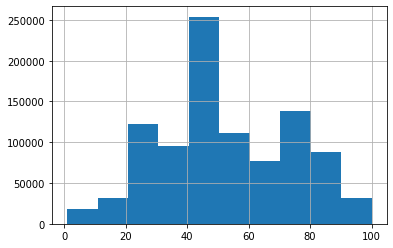

In [10]:
orders_df.city_name.hist()

In [11]:
## Preprocess Products
pathes = sorted(list(Path(DATA_PATH).glob('*/tab_2*.csv')))
dfs = []

for path in tqdm(pathes):
    # Read DF
    df = pd.read_csv(path)
    
    # Filter and delete users not from test
    df = df[df.user_id.isin(test_user_ids)]

    # Drop column with long desciption
    df.drop(columns=["product_name"], inplace=True)
    
    # Label code column
    df.brand_name = df.brand_name.astype('category').cat.codes
    
    # Fill NaNs in one column
    df.master_category_id.fillna(-1, inplace=True)
    dfs.append(df)

In [12]:
products_df = pd.concat(dfs)
print("Num rows in filtered products:", len(products_df)) # 21677070
print("Num unique products:", products_df.product_id.nunique()) # 91994

Num rows in filtered products: 21677070
Num unique products: 91994


In [13]:
# Compare `orders_id`
orders_from_orders = set(orders_df.order_id)
orders_from_products = set(products_df.order_id)
print(f"Orders: {len(orders_from_orders)}, Products: {len(orders_from_products)}")
print(f"Intersection: {len(orders_from_orders.intersection(orders_from_products))}")
print(f"Union orders: {len(orders_from_orders.difference(orders_from_products))}")
print(f"Union products: {len(orders_from_products.difference(orders_from_orders))}")

# Not for all users/orders in Products table we can find corresponding element in Orders to get additional features

Orders: 953436, Products: 839874
Intersection: 792285
Union orders: 161151
Union products: 47589


In [14]:
# Mean order size per user
mean_orders = (products_df.groupby(["user_id", "order_id"])
                         .agg({'line_item_id':'count'})
                         .groupby("user_id").mean()
                         .rename(columns={'line_item_id':'mean_order_size'}))

products_df = products_df.merge(mean_orders, on='user_id')

In [15]:
# Merge Orders data
tmp = orders_df.drop_duplicates("order_id").drop(columns="user_id")
products_df = products_df.merge(tmp, how='left', on='order_id')
products_df.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,mean_order_size,store_id,order_created_time,retailer,platform,city_name,gender,age,day_since_prior_order
0,766,5395508,28998751,24.270000,3,0.000000,3069043,2260,77.0,74,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,766,5395508,28998796,79.300003,3,0.000000,3041849,1856,26.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,766,5395508,28999083,76.620003,5,15.070000,216,1375,607.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,766,5395508,28999153,72.180000,1,19.540001,1990,1292,32.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,766,5395508,28999278,142.500000,3,0.000000,3883053,1397,31.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
len(products_df)

21677070

## Convert products df into training data for logistic regression

In [ ]:
#     # Change data types to reduce memory footprint
#     df.astype({
#         'user_id': 'int32',
#         'order_id': 'int32',
#         'price': 'float32',
#         'quantity': 'int32',
#         'discount': 'float32',
#         'product_id': 'int32',
#         'brand_name': 'int32',
#         'master_category_id': 'int32',
#         'parent_category_id': 'int32'}, copy=False)

In [8]:
# Can be slow, just wait =)
merged_df = products_df.set_index('order_id').join(orders_df.set_index('order_id'))
merged_df.reset_index(inplace=True)
print("Total:", len(merged_df))

Total: 21677070


In [9]:
merged_df.head()

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,139128,1050,97633689,236.889999,1,0.0,5045454,3573,122.0,119,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,139128,1050,97633791,178.160004,1,0.0,73719,5154,122.0,119,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,139128,1050,97635201,173.279999,1,0.0,7000939,2846,85.0,84,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,139128,1050,97635312,73.690002,1,0.0,7386015,3342,85.0,84,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,139128,1050,97635414,282.140015,1,0.0,73291,2846,85.0,84,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [10]:
merged_df.fillna(value=-1, inplace=True)

In [11]:
merged_df.dtypes

order_id                int64
user_id                 int64
line_item_id            int64
price                 float64
quantity                int64
discount              float64
product_id              int64
brand_name              int16
master_category_id    float64
parent_category_id      int64
order_created_time     object
retailer              float64
platform              float64
city_name             float64
gender                float64
bdate                  object
age                   float64
dtype: object

In [12]:
# Change data types to reduce memory footprint
merged_df = merged_df.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'retailer': 'int16',
    'platform': 'int8',
    'city_name': 'int16',
    'gender': 'int8',
    'age': 'int8',
    }, copy=True)

In [13]:
merged_df.dtypes

order_id                int32
user_id                 int32
line_item_id            int64
price                 float32
quantity                int32
discount              float32
product_id              int32
brand_name              int32
master_category_id      int32
parent_category_id      int32
order_created_time     object
retailer                int16
platform                 int8
city_name               int16
gender                   int8
bdate                  object
age                      int8
dtype: object

In [15]:
merged_df.head()

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,139128,1050,97633689,236.889999,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,139128,1050,97633791,178.160004,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,139128,1050,97635201,173.279999,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,139128,1050,97635312,73.690002,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,139128,1050,97635414,282.140015,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [14]:
merged_df.to_csv(os.path.join(DATA_PATH, "merged_data.csv"))

In [36]:
merged_df.product_id.value_counts()

0          210347
709        139570
39590       44804
166         36970
55133       34424
            ...  
7030736         1
9122012         1
5571748         1
6748166         1
8016826         1
Name: product_id, Length: 91994, dtype: int64

In [124]:
merged_df['count'] = 1
df_agg = merged_df.groupby(["user_id", "product_id"]).agg({'count':sum})
g = df_agg['count'].groupby(level=0, group_keys=False)

In [125]:
res = g.nlargest(50)
res.reset_index(inplace=True)
res.product_id = res.product_id.astype('str')
submit = res.groupby('user_id')['product_id'].apply(' '.join).reset_index()
submit.columns = ["Id", "Predicted"]
submit.to_csv("my_sumbit1.csv", index=False)